[https://www.kaggle.com/code/stoicstatic/face-recognition-siamese-w-triplet-loss#Creating-the-Model](https://www.kaggle.com/code/stoicstatic/face-recognition-siamese-w-triplet-loss#Creating-the-Model)

In [1]:
# Mounting google drive
from google.colab import drive

drive.mount("/content/gdrive")

!ls "/content/gdrive/My Drive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
colab  IT  udacity


In [2]:
# Setting workspace root folder in google drive
ROOT_DIR = "/content/gdrive/My Drive/colab/Omdena/egypt-chapter/orphanage-well-being/src/tasks/task-3-face-recognition-system/ekoue/deep facial recognition"
# tasks\task-3-face-recognition-system\ekoue\deep facial recognition
ROOT_DIR

'/content/gdrive/My Drive/colab/Omdena/egypt-chapter/orphanage-well-being/src/tasks/task-3-face-recognition-system/ekoue/deep facial recognition'

In [3]:
import os

os.chdir(ROOT_DIR)

!pwd

/content/gdrive/My Drive/colab/Omdena/egypt-chapter/orphanage-well-being/src/tasks/task-3-face-recognition-system/ekoue/deep facial recognition


In [4]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.12.0', '1.23.5')

In [5]:
DEV_MODE=False # If True, will only select a subset of data to train on, to make sure that the notebook is without error
DEV_MODE

False

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

# Define dataset folder
if not DEV_MODE:
    DATASET_ROOT = "../../../../data/dataset" #"../input/face-recognition-dataset/Extracted Faces/Extracted Faces"
else:
    DATASET_ROOT = "../../../../data/dataset_dev"

DATASET_ROOT

'../../../../data/dataset'

In [8]:
def rename_folders_and_files(dataset_folder:str):
    """
        Renaming dataset sub-folders and files according to the code requirements:
            - folder are renamed from 0 to number of folder-1
            - files are renamed from 0 to number of files-1
    """


    separator="---"

    ######################  Renaming folders from 0 to number of folder-1 ########################

    # Get folders, each one containing the images of a given person
    folders = [f for f in os.listdir(dataset_folder) if not os.path.isfile(f)]
#     print("folders")
#     print(folders)

    # Adding indexes at the start of each folder
    for folder in folders:
        # get index of the folder
        idx = folders.index(folder)
        src_path = os.path.join(dataset_folder,folder)
        dest_path = os.path.join(dataset_folder, f"{idx}{separator}{folder}")
#         print(f"src_path: {src_path}")
#         print(f"dest_path: {dest_path}")
        os.rename(src_path, dest_path)

    # Get new folders name
    folders = [f for f in os.listdir(dataset_folder) if not os.path.isfile(f)]

    # Rename folders: only keep their index in their name
    for folder in folders:
        src_path = os.path.join(dataset_folder,folder)
        idx = folder.split(separator)[0]
        dest_path = os.path.join(dataset_folder, idx)
#         print(f"src_path: {src_path}")
#         print(f"dest_path: {dest_path}")
        os.rename(src_path, dest_path)


    ######################  Renaming files from 0 to number of files-1 ########################
    # Get new folders name
    folders = [f for f in os.listdir(dataset_folder) if not os.path.isfile(f)]
    # Rename the files in each folder
    for folder in folders:
        print(f"Processing folder '{folder}'")


        # Get files name
        files = [f for f in os.listdir(os.path.join(dataset_folder, folder)) if os.path.isfile(os.path.join(dataset_folder, folder, f)) ] #  if os.path.isfile(f)
#         print("files")
#         print(files)

        # Adding indexes at the start of each file
        for file in files:
            # get index of the file
            idx = files.index(file)
            src_path = os.path.join(dataset_folder,folder,file)
            dest_path = os.path.join(dataset_folder,folder, f"{idx}{separator}{file}")
#             print(f"src_path: {src_path}")
#             print(f"dest_path: {dest_path}")
            os.rename(src_path, dest_path)

        # Get new files name
        files = [f for f in os.listdir(os.path.join(dataset_folder, folder)) if os.path.isfile(os.path.join(dataset_folder, folder, f)) ]
#         print("files")
#         print(files)

        # Rename files: only keep their index in their name
        for file in files:
            src_path = os.path.join(dataset_folder,folder, file)
            idx = file.split(separator)[0]
            extention = os.path.splitext(src_path)[1]
            dest_path = os.path.join(dataset_folder,folder, f"{idx}{extention}")
#             print(f"src_path: {src_path}")
#             print(f"dest_path: {dest_path}")
            os.rename(src_path, dest_path)

    print("All folders processed")


In [9]:
rename_folders_and_files(DATASET_ROOT)

In [10]:
def read_image(index):
    """
        Read an image, resize it to 128x128 (to fit the input size of the transfered model), and make sure it is in RGB format
    """
    path = os.path.join(DATASET_ROOT, index[0], index[1])
#     print("path:", path)
    image = cv2.imread(path)
    # if image is None:
    #   raise Exception(f"Image at {path} is unreadable")

    image = cv2.resize(image, (128, 128))

#     image = image.astype(np.float32)
    # Convert the image from BGR input channel to RGB input channel
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [11]:
def split_dataset(directory, split=0.9):
    """
        Split dataset into training and test sets
        @param:
            directory: dataset root folder
        @return
            Return a tuple of two dictionaries respectively for training and test sets, where:
                - keys are the sub-folders (containing the images)
                - values are the number of files in each sub-folder
    """

    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    print("num_train:", num_train)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    # TODO: create a validation list

    return train_list, test_list

In [12]:
train_list, test_list = split_dataset(DATASET_ROOT, split=0.8)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))


num_train: 24
Length of training list: 24
Length of testing list : 6


In [13]:
# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", {k: test_list[k] for k in sorted(test_list.keys())[:2]} )


Test List: {'11': 639, '19': 395}


In [14]:
# train_list
{k: train_list[k] for k in sorted(train_list.keys())[:5]}

{'0': 711, '1': 465, '10': 639, '12': 532, '13': 530}

## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [15]:
def create_triplets(directory, folder_list, max_files=10):
    """
        Create a triplet of (anchor, positive, negative) images
        Each of anchor, positive, negative is a tuple consisting of:
            - sub-folder containing the image, at index 0
            - image, at index 1
    """
    triplets = []
    folders = list(folder_list.keys())
    print(f"Folders: {folders}")

    print(f"Started processing (a total of {len(folders)}) folders...")
    print("=============="*3)
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        print(f"Processing folder {folder} ({num_files} files)")
        print(f"Files: {files}")

        #files = [f for f in os.listdir() if os.path.isfile(f)]


        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg") # (folder, f"{files[i]}") #
                positive = (folder, f"{j}.jpg") # (folder, f"{files[j]}") #

                neg_folder = folder
                same_choice_count=0
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
#                     print(f"Choosed {neg_folder} as negative folder")
                    if neg_folder== folder:
                        same_choice_count+=1
                        if same_choice_count==3:
                            raise Exception("Choosed same folder as negative {same_choice_count} times")
#                 print(f"Choosed {neg_folder} as negative folder")
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

#                 neg_path = os.path.join(directory, neg_folder)
#                 neg_files = list(os.listdir(neg_path))[:max_files]
#                 neg_file_idx = random.randint(0, len(neg_files)-1)
#                 neg_file = neg_files[neg_file_idx]
#                 negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [16]:
train_triplet = create_triplets(DATASET_ROOT, train_list)

len(train_triplet)

Folders: ['4', '26', '13', '2', '10', '9', '29', '24', '12', '17', '28', '6', '15', '18', '21', '3', '5', '1', '7', '14', '0', '16', '20', '27']
Started processing (a total of 24) folders...
Processing folder 4 (10 files)
Files: ['184.jpg', '198.jpg', '237.jpg', '248.jpg', '249.jpg', '250.jpg', '254.jpg', '255.jpg', '261.jpg', '264.jpg']
Processing folder 26 (10 files)
Files: ['0.jpg', '325.jpg', '69.jpg', '115.jpg', '470.jpg', '478.jpg', '399.jpg', '130.jpg', '62.jpg', '264.jpg']
Processing folder 13 (10 files)
Files: ['159.jpg', '429.jpg', '102.jpg', '249.jpg', '300.jpg', '493.jpg', '222.jpg', '215.jpg', '28.jpg', '385.jpg']
Processing folder 2 (10 files)
Files: ['221.jpg', '245.jpg', '433.jpg', '455.jpg', '501.jpg', '552.jpg', '28.jpg', '43.jpg', '70.jpg', '90.jpg']
Processing folder 10 (10 files)
Files: ['16.jpg', '116.jpg', '112.jpg', '108.jpg', '133.jpg', '175.jpg', '191.jpg', '15.jpg', '124.jpg', '105.jpg']
Processing folder 9 (10 files)
Files: ['10.jpg', '1.jpg', '101.jpg', '10

1080

In [17]:
test_triplet  = create_triplets(DATASET_ROOT, test_list)

len(test_triplet)

Folders: ['22', '25', '11', '23', '8', '19']
Started processing (a total of 6) folders...
Processing folder 22 (10 files)
Files: ['134.jpg', '188.jpg', '183.jpg', '149.jpg', '143.jpg', '164.jpg', '117.jpg', '193.jpg', '140.jpg', '21.jpg']
Processing folder 25 (10 files)
Files: ['151.jpg', '134.jpg', '260.jpg', '299.jpg', '350.jpg', '192.jpg', '145.jpg', '45.jpg', '13.jpg', '263.jpg']
Processing folder 11 (10 files)
Files: ['207.jpg', '490.jpg', '163.jpg', '422.jpg', '344.jpg', '517.jpg', '156.jpg', '219.jpg', '326.jpg', '315.jpg']
Processing folder 23 (10 files)
Files: ['185.jpg', '262.jpg', '248.jpg', '205.jpg', '100.jpg', '245.jpg', '260.jpg', '220.jpg', '12.jpg', '169.jpg']
Processing folder 8 (10 files)
Files: ['167.jpg', '228.jpg', '13.jpg', '166.jpg', '125.jpg', '77.jpg', '186.jpg', '52.jpg', '84.jpg', '193.jpg']
Processing folder 19 (10 files)
Files: ['6.jpg', '328.jpg', '19.jpg', '364.jpg', '158.jpg', '106.jpg', '233.jpg', '26.jpg', '359.jpg', '157.jpg']


270

In [18]:
print("\nExamples of triplets (anchor, positive, negative):")
for i in range(5):
    print(train_triplet[i])


Examples of triplets (anchor, positive, negative):
(('17', '0.jpg'), ('17', '4.jpg'), ('6', '206.jpg'))
(('17', '0.jpg'), ('17', '7.jpg'), ('7', '83.jpg'))
(('10', '0.jpg'), ('10', '8.jpg'), ('5', '330.jpg'))
(('24', '6.jpg'), ('24', '7.jpg'), ('0', '412.jpg'))
(('3', '7.jpg'), ('3', '9.jpg'), ('24', '339.jpg'))


In [19]:
print("\nExamples of triplets (anchor, positive, negative):")
for i in range(5):
    print(test_triplet[i])


Examples of triplets (anchor, positive, negative):
(('8', '1.jpg'), ('8', '3.jpg'), ('23', '48.jpg'))
(('25', '0.jpg'), ('25', '7.jpg'), ('19', '288.jpg'))
(('8', '3.jpg'), ('8', '9.jpg'), ('25', '51.jpg'))
(('22', '1.jpg'), ('22', '6.jpg'), ('25', '148.jpg'))
(('11', '1.jpg'), ('11', '9.jpg'), ('19', '233.jpg'))


## Creating Batch-Generator
<!-- Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

### Parameters:

* **Batch_size**: Batch_size of the data to return
* **Preprocess**: Whether to preprocess the data or not -->

In [20]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    """
        Creating a Batch-Generator that converts the triplets passed into
        batches of face-data and preproccesses it before returning the
        data into seperate lists.

        @params:
            - batch_size: Batch_size of the data to return
            - preprocess: Whether to preprocess the data or not

        eg. of triplet_list containt: [(anchor, positive, negative)], with each of them being (sub-folder containing the image, image name):
            [(('5', '0.jpg'), ('5', '2.jpg'), ('8', '0.jpg')),
             (('6', '0.jpg'), ('6', '2.jpg'), ('11', '0.jpg'))]
    """

    # Compute number of batches that will be generated
    batch_steps = len(triplet_list)//batch_size

    # Run through each batch of data
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        # For each image in the current batch: keep it as an anchor, while retrieving one of its positives and one of its negatives
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j] #  will return a tuple like this: ('5', '0.jpg'), ('5', '2.jpg'), ('8', '0.jpg')
#             print(f"a :{a}")
            j+=1

            try:
              anchor.append(read_image(a))
              positive.append(read_image(p))
              negative.append(read_image(n))

            except:
              continue

        # Parsing the lists of anchor, positive, negative into numpy arrays
        anchor = np.array(anchor) # np.array(anchor, dtype=object)
        positive = np.array(positive) # np.array(positive, dtype=object) #
        negative =  np.array(negative) #  np.array(negative, dtype=object) #


        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

In [21]:
train_triplet[:2]

[(('17', '0.jpg'), ('17', '4.jpg'), ('6', '206.jpg')),
 (('17', '0.jpg'), ('17', '7.jpg'), ('7', '83.jpg'))]

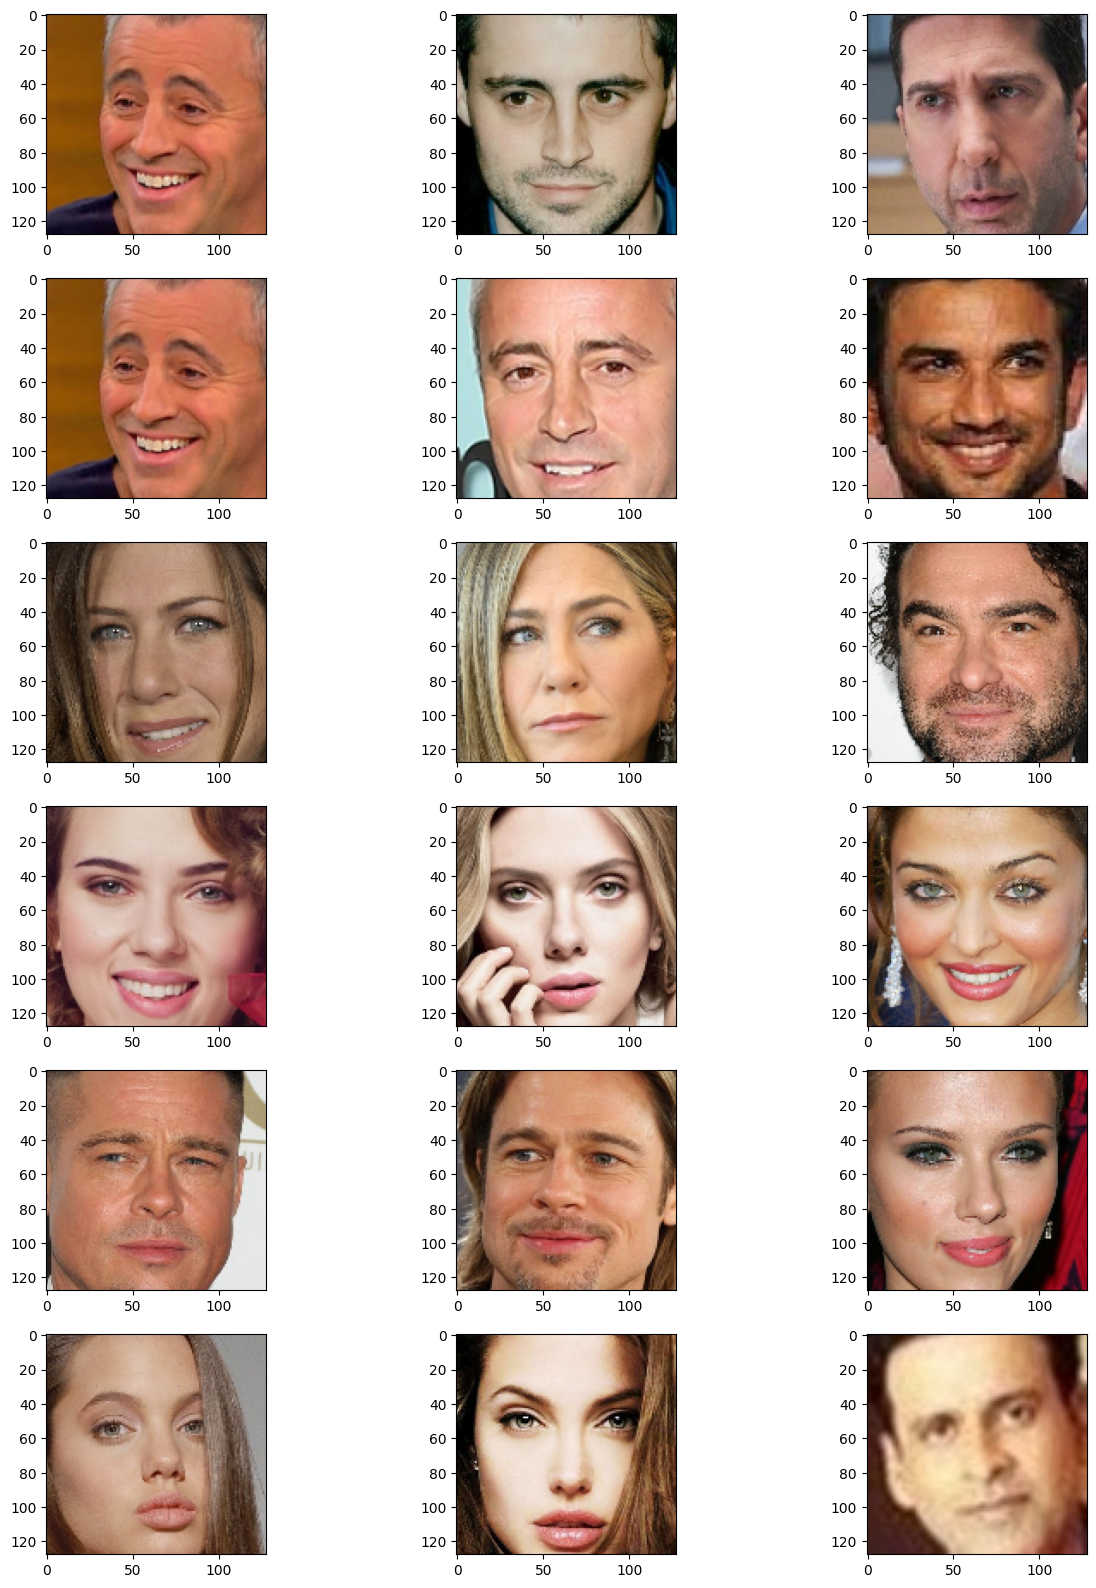

In [22]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
#     print(x)
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

<img src="./assets/siamese network.png"
     alt="Siamese Network"
     style="float: left; margin-right: 10px;" />

In [23]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [24]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    # Get a pre-trained model
    pretrained_model = Xception(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False,
        pooling="avg",
    )

    # Freeze all layers of the pre-trained model except the last 27 ones (presumably, freezing the backbone of the pre-trained model)
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    # Adding an embedding layer as well as a head to the pre-trained model
    encode_model = Sequential([
        pretrained_model,

        layers.Flatten(),

        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(.3), # my own adding

        layers.Dense(256, activation="relu"),

        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))

    ], name="Encoded_FaceIdentification_Model")

    return encode_model

## Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

<img src="./assets/siamese distance formula.png"
     alt="Siamese distance formula"
     style="float: left; margin-right: 10px;" />

In [25]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [26]:
def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
#     distances = DistanceLayer()(
#         encoder(anchor_input),
#         encoder(positive_input),
#         encoder(negative_input)
#     )
    distances = DistanceLayer()(encoded_a,encoded_p,encoded_n)

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network


In [27]:
siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                   

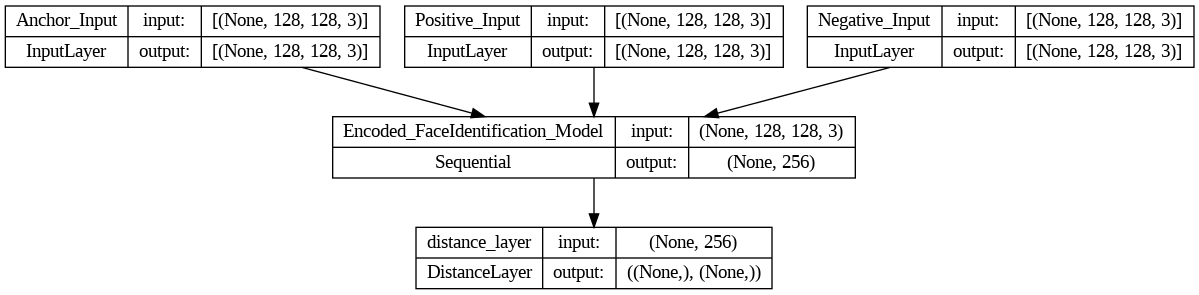

In [28]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

<img src="./assets/triplet loss function.png"
     alt="Triplet loss function"
     style="float: left; margin-right: 10px;" />

In [29]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [30]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)

siamese_model, optimizer

(<__main__.SiameseModel at 0x7a236cf81240>,
 <keras.optimizers.adam.Adam at 0x7a236d580070>)

In [31]:
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.


### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [32]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [33]:
CHECKPOINT_FOLDER = "./checkpoints"

In [34]:
# np.array(train_triplet)

In [35]:
np.array(train_triplet).shape

(1080, 3, 2)

In [36]:
np.array(train_triplet)[0]

array([['17', '0.jpg'],
       ['17', '4.jpg'],
       ['6', '206.jpg']], dtype='<U8')

In [37]:
train_triplet[0]

(('17', '0.jpg'), ('17', '4.jpg'), ('6', '206.jpg'))

https://www.tensorflow.org/tutorials/keras/save_and_load

In [38]:
save_all = False
if not DEV_MODE:
    epochs = 256
else:
    epochs = 2

batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights(f"{CHECKPOINT_FOLDER}/siamese_model.h5")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights(f"{CHECKPOINT_FOLDER}/siamese_model-final.h5")


EPOCH: 1 	 (Epoch done in 896 sec)
Loss on train    = 0.70558
1/1 [==============================] - 6s 6s/step
Accuracy on test = 0.69630

EPOCH: 2 	 (Epoch done in 440 sec)
Loss on train    = 0.46390
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.67778

EPOCH: 3 	 (Epoch done in 434 sec)
Loss on train    = 0.32023
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.72963

EPOCH: 4 	 (Epoch done in 427 sec)
Loss on train    = 0.21732
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.73704

EPOCH: 5 	 (Epoch done in 432 sec)
Loss on train    = 0.13996
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.76667

EPOCH: 6 	 (Epoch done in 430 sec)
Loss on train    = 0.08841
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.61852

EPOCH: 7 	 (Epoch done in 436 sec)
Loss on train    = 0.05371
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.64444

EPOCH: 8 	 (Epoch d

KeyboardInterrupt: ignored

## Evaluating the model

In [39]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()

    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))

    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

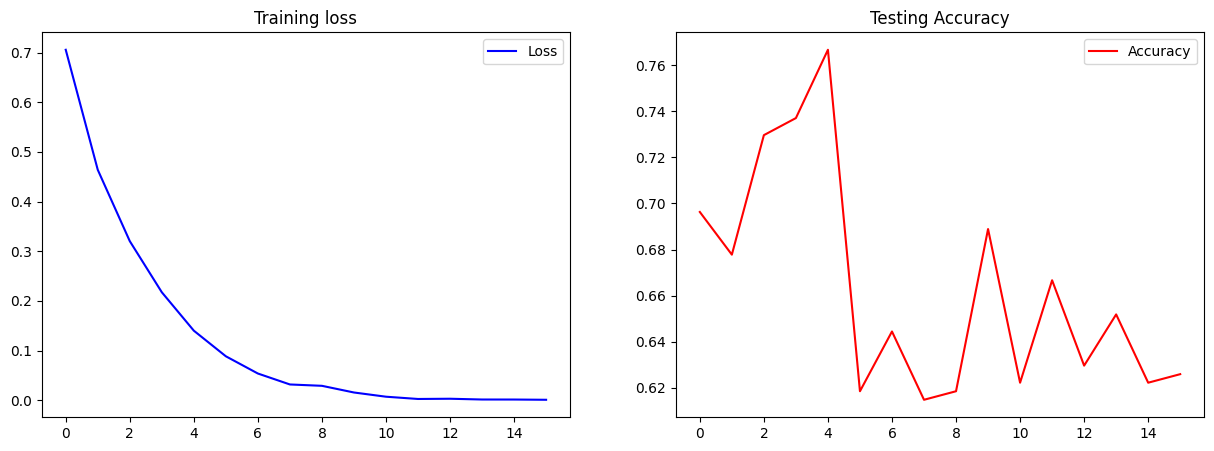

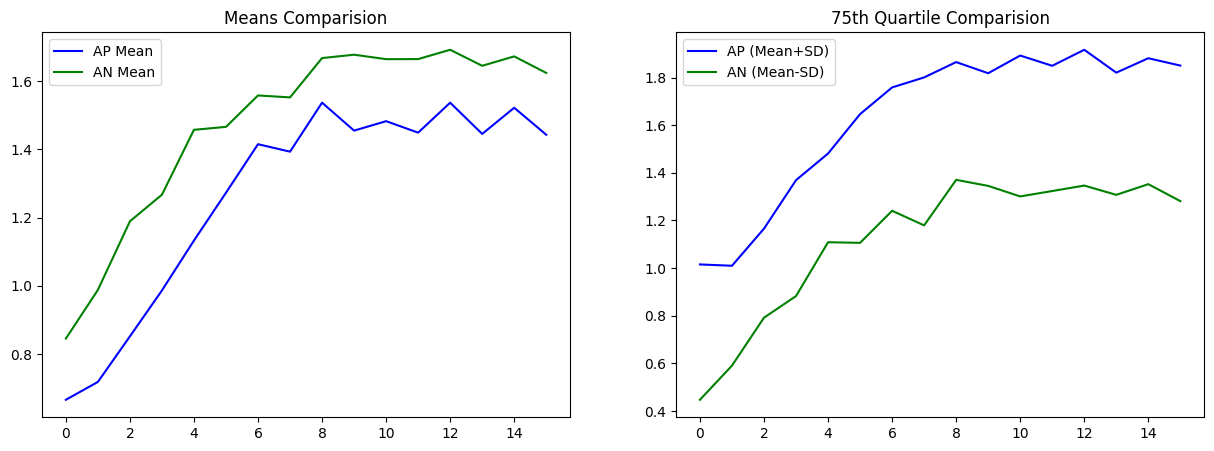

In [40]:
test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [41]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights(f"{CHECKPOINT_FOLDER}/encoder.h5")
encoder.summary()

Model: "Encoded_FaceIdentification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                  

### Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [42]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [43]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


8/8 [==============================] - 20s 2s/step

Accuracy of model: 0.576171875



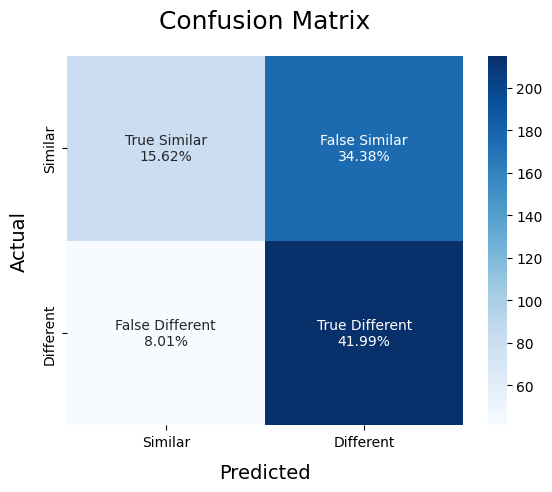

In [44]:
pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [ ]:
# Exporting work to google drive
# !scp -r /content/runs '/content/gdrive/My Drive/Workbench/colab-code/Omdena/egypt/orphanage-cv'